# **Biometric Swipe-Based Anomaly Detection System using Binary Classification**
### **Student Name:** Saathwick Venkataramalingam  
### **Student Number:** 1330861  

---

In [1]:
#Biometric Swipe-Based Anomaly Detection System using Binary Classification
#Student Name: Saathwick Venkataramalingam
#Student Number: 1330861
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

# For environments that require in-notebook package installations (if applicable)
try:
    import micropip
    await micropip.install("seaborn")
except Exception as e:
    pass


In [2]:
# Cell 2: Load Dataset and Assign Column Names
df = pd.read_csv("featMat.csv", header=None)
df.columns = [
    'user id', 'doc id', 'inter-stroke time', 'stroke duration', 'start $x$', 
    'start $y$', 'stop $x$', 'stop $y$', 'direct end-to-end distance', 
    'mean resultant length', 'up/down/left/right flag', 'direction of end-to-end line', 
    'phone id', '20%-perc. pairwise velocity', '50%-perc. pairwise velocity', 
    '80%-perc. pairwise velocity', '20%-perc. pairwise acc', '50%-perc. pairwise acc', 
    '80%-perc. pairwise acc', 'median velocity at last 3 pts', 
    'largest deviation from end-to-end line', '20%-perc. dev. from end-to-end line', 
    '50%-perc. dev. from end-to-end line', '80%-perc. dev. from end-to-end line', 
    'average direction', 'length of trajectory', 
    'ratio end-to-end dist and length of trajectory', 'average velocity', 
    'median acceleration at first 5 points', 'mid-stroke pressure', 
    'mid-stroke area covered', 'mid-stroke finger orientation', 
    'change of finger orientation', 'phone orientation'
]
print("Data Overview:")
print(df.head())
print("Data shape:", df.shape)

Data Overview:
   user id  doc id  inter-stroke time  stroke duration  start $x$  start $y$  \
0       37       4              0.341            0.256     27.416    -27.113   
1       37       4              0.913            0.086     21.771    -30.037   
2       37       4              0.733            0.111     10.886    -34.169   
3       37       4              0.448            0.094     19.151    -34.572   
4       37       4              0.519            0.056     27.718    -32.758   

   stop $x$  stop $y$  direct end-to-end distance  mean resultant length  ...  \
0   12.3980   -32.960                     16.1160                0.35736  ...   
1    9.8778   -33.867                     12.4950                0.26504  ...   
2   26.9120   -34.673                     16.0340                0.99118  ...   
3   12.7000   -36.790                      6.8213                0.59647  ...   
4   14.6150   -37.294                     13.8660                0.67819  ...   

   average direct

In [3]:
# Cell 3: Data Cleaning and Preprocessing
# Keep 'user id' (for later labeling) and drop non-informative columns ('doc id', 'phone id')
df_features = df.drop(columns=['doc id', 'phone id'], errors='ignore')

# Replace infinite values with NaN and drop rows with missing values
df_features_clean = df_features.replace([np.inf, -np.inf], np.nan).dropna()
print("Shape after cleaning:", df_features_clean.shape)
df_features_clean.head()

Shape after cleaning: (20848, 32)


,user id,inter-stroke time,stroke duration,start $x$,start $y$,stop $x$,stop $y$,direct end-to-end distance,mean resultant length,up/down/left/right flag,...,average direction,length of trajectory,ratio end-to-end dist and length of trajectory,average velocity,median acceleration at first 5 points,mid-stroke pressure,mid-stroke area covered,mid-stroke finger orientation,change of finger orientation,phone orientation
0,37,0.341,0.256,27.416,-27.113,12.3980,-32.960,16.1160,0.35736,4,...,-2.581200,16.1320,0.99898,63.018,-432.24,0.32,0.044444,0.0,0,1
1,37,0.913,0.086,21.771,-30.037,9.8778,-33.867,12.4950,0.26504,4,...,-2.199400,12.5960,0.99197,146.470,5117.70,0.60,0.088889,0.0,0,1
2,37,0.733,0.111,10.886,-34.169,26.9120,-34.673,16.0340,0.99118,2,...,0.086288,16.2030,0.98959,145.970,-3563.50,0.48,0.044444,0.0,0,1
3,37,0.448,0.094,19.151,-34.572,12.7000,-36.790,6.8213,0.59647,4,...,-2.723100,6.9674,0.97902,74.122,-4604.10,0.40,0.044444,0.0,0,1
4,37,0.519,0.056,27.718,-32.758,14.6150,-37.294,13.8660,0.67819,4,...,-2.717000,13.8710,0.99965,247.690,-21377.00,0.44,0.044444,0.0,0,1


Shape after Standard Scaling: (20848, 31)
Number of components required for 90% variance: 15
Original shape: (20848, 31)
Reduced shape (PCA): (20848, 15)


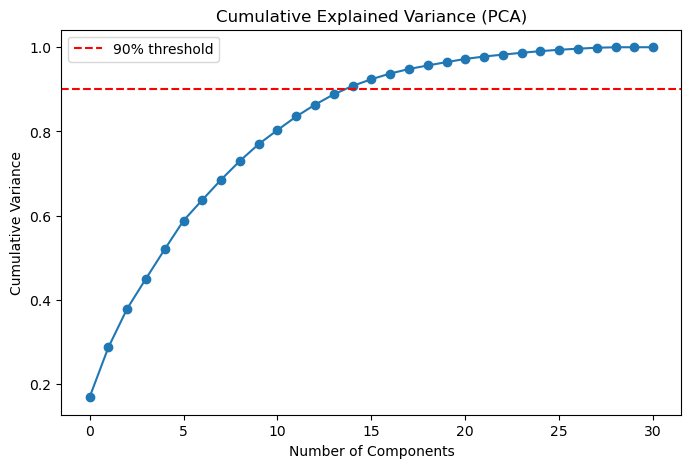

In [4]:
# Cell 4: Feature Scaling with StandardScaler and PCA (retain 90% variance)
# Separate 'user id' and feature data
user_ids = df_features_clean['user id']
X_raw = df_features_clean.drop(columns=['user id'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
print("Shape after Standard Scaling:", X_scaled.shape)

# Determine the number of PCA components required for 90% variance
from sklearn.decomposition import PCA
pca_full = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print("Number of components required for 90% variance:", n_components_90)

# Apply PCA
pca = PCA(n_components=n_components_90, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Original shape:", X_scaled.shape)
print("Reduced shape (PCA):", X_pca.shape)

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.show()

# Create a DataFrame with the PCA-reduced data and reattach 'user id'
df_pca = pd.DataFrame(X_pca)
df_pca['user id'] = user_ids.values


C:\Users\Wick\AppData\Local\Temp\ipykernel_13916\643699286.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df_features_clean['start $x$'], y=df_features_clean['start $y$'], cmap="Reds", shade=True, bw_adjust=0.5)


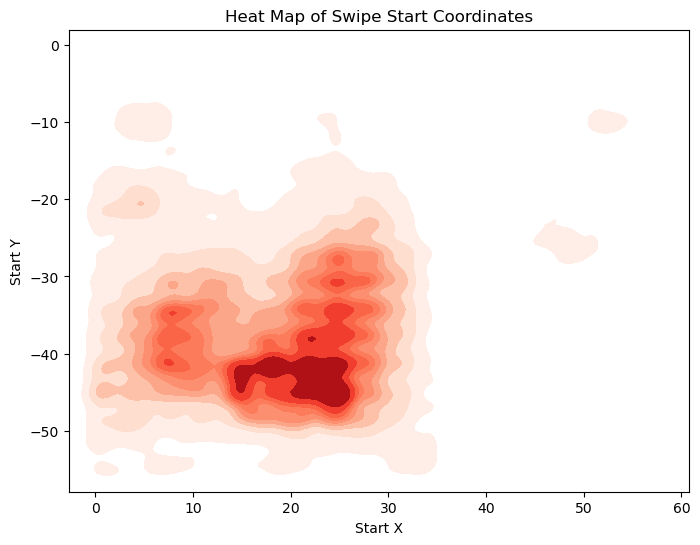

Takeaway: Swipes predominantly begin in a central region, suggesting common touch initiation areas.


In [5]:
# Cell 5: Visualization 1 - Heat Map of Swipe Start Coordinates
plt.figure(figsize=(8,6))
sns.kdeplot(x=df_features_clean['start $x$'], y=df_features_clean['start $y$'], cmap="Reds", shade=True, bw_adjust=0.5)
plt.title("Heat Map of Swipe Start Coordinates")
plt.xlabel("Start X")
plt.ylabel("Start Y")
plt.show()
print("Takeaway: Swipes predominantly begin in a central region, suggesting common touch initiation areas.")

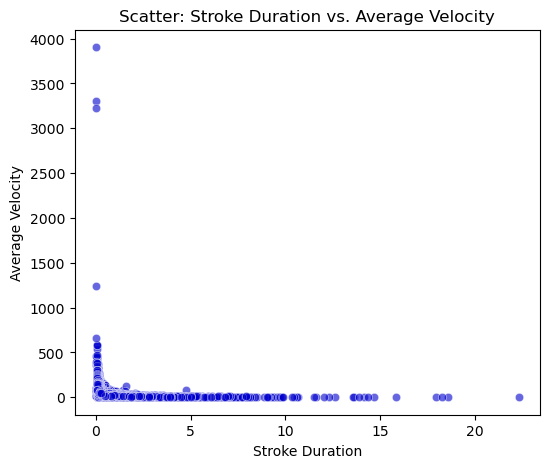

Takeaway: Most swipes cluster at low duration and velocity, with few outliers indicating unusual behavior.


In [6]:
# Cell 6: Visualization 2 - Key Feature Relationships
# 6: Scatter Plot: Stroke Duration vs. Average Velocity
plt.figure(figsize=(6,5))
sns.scatterplot(x='stroke duration', y='average velocity', data=df_features_clean, color='mediumblue', alpha=0.6)
plt.title("Scatter: Stroke Duration vs. Average Velocity")
plt.xlabel("Stroke Duration")
plt.ylabel("Average Velocity")
plt.show()
print("Takeaway: Most swipes cluster at low duration and velocity, with few outliers indicating unusual behavior.")



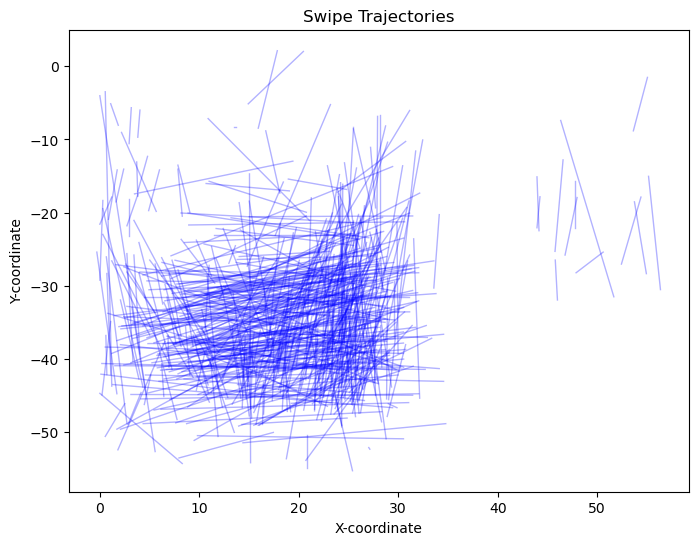

Takeaway: The swipe trajectories reveal typical swipe paths and highlight variability in user behavior.


In [7]:
# Cell 7: Visualization 3 - Swipe Trajectories
# Sample a subset of swipes (e.g., 500) for clarity
sample_df = df_features_clean.sample(n=500, random_state=42)

plt.figure(figsize=(8,6))
for idx, row in sample_df.iterrows():
    plt.plot([row['start $x$'], row['stop $x$']], 
             [row['start $y$'], row['stop $y$']], 
             color='blue', alpha=0.3, linewidth=1)
plt.title("Swipe Trajectories")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
print("Takeaway: The swipe trajectories reveal typical swipe paths and highlight variability in user behavior.")

In [8]:
# Cell 8: Select Users and Split Each User's Data into Train/Test (70/30 split)
unique_users = list(df_pca['user id'].unique())
print("Total unique users after processing:", len(unique_users))

# For demonstration, randomly select 5 users
random.seed(42)
selected_users = random.sample(unique_users, 5)
print("Selected Users for model building:", selected_users)

Total unique users after processing: 41
Selected Users for model building: [13, 34, 1, 19, 21]


In [9]:
# Cell 9: Function to Prepare Train-Test Data for a Specific User
def prepare_train_test_data_for_user(df, target_user, train_ratio=0.7):
    """
    For a given target_user, prepare training and testing data.
    Positive samples: rows where user id == target_user.
    Negative samples: rows where user id is in the selected_users but not target_user.
    Splits both positive and negative samples into training/test sets using train_ratio.
    Returns: X_train, y_train, X_test, y_test.
    """
    pos = df[df['user id'] == target_user].copy()
    neg = df[(df['user id'] != target_user) & (df['user id'].isin(selected_users))].copy()

    from sklearn.model_selection import train_test_split
    pos_train, pos_test = train_test_split(pos, train_size=train_ratio, random_state=42)
    neg_train, neg_test = train_test_split(neg, train_size=train_ratio, random_state=42)

    train_df = pd.concat([pos_train, neg_train])
    test_df = pd.concat([pos_test, neg_test])

    train_df['label'] = train_df['user id'].apply(lambda x: 1 if x == target_user else 0)
    test_df['label'] = test_df['user id'].apply(lambda x: 1 if x == target_user else 0)

    X_train = train_df.drop(columns=['user id', 'label']).values
    y_train = train_df['label'].values
    X_test = test_df.drop(columns=['user id', 'label']).values
    y_test = test_df['label'].values

    return X_train, y_train, X_test, y_test

# Quick test for one user
example_user = selected_users[0]
X_train_sample, y_train_sample, X_test_sample, y_test_sample = prepare_train_test_data_for_user(df_pca, example_user, train_ratio=0.7)
print(f"User {example_user} Training Data Shape: {X_train_sample.shape}")
print("Class distribution (Training):", np.bincount(y_train_sample))
print(f"User {example_user} Testing Data Shape: {X_test_sample.shape}")
print("Class distribution (Testing):", np.bincount(y_test_sample))

User 13 Training Data Shape: (1598, 15)
Class distribution (Training): [1385  213]
User 13 Testing Data Shape: (686, 15)
Class distribution (Testing): [594  92]


In [10]:
# Cell 10: Train User-Specific Classifiers for Each Selected User

models_lr = {}   # Logistic Regression models
models_rf = {}   # Random Forest models
models_svc = {}  # SVC models
train_test_data = {}  # store the train-test splits for each user

for user in selected_users:
    X_train, y_train, X_test, y_test = prepare_train_test_data_for_user(df_pca, user, train_ratio=0.7)
    
    # Train Logistic Regression
    clf_lr = LogisticRegression(max_iter=1000, random_state=42)
    clf_lr.fit(X_train, y_train)
    
    # Train Random Forest
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_rf.fit(X_train, y_train)
    
    # Train SVC (with probability estimates enabled)
    clf_svc = SVC(probability=True, random_state=42)
    clf_svc.fit(X_train, y_train)
    
    models_lr[user] = clf_lr
    models_rf[user] = clf_rf
    models_svc[user] = clf_svc
    train_test_data[user] = (X_train, y_train, X_test, y_test)
    
    print(f"Trained models for User {user} | Positives: {np.sum(y_train==1)}; Negatives: {np.sum(y_train==0)}")


Trained models for User 13 | Positives: 213; Negatives: 1385
Trained models for User 34 | Positives: 424; Negatives: 1173
Trained models for User 1 | Positives: 266; Negatives: 1332
Trained models for User 19 | Positives: 204; Negatives: 1394
Trained models for User 21 | Positives: 489; Negatives: 1108


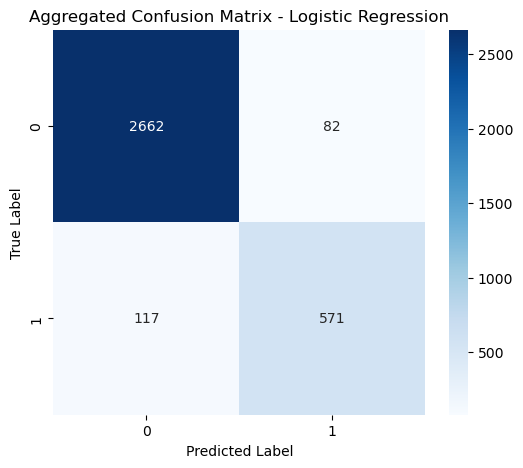

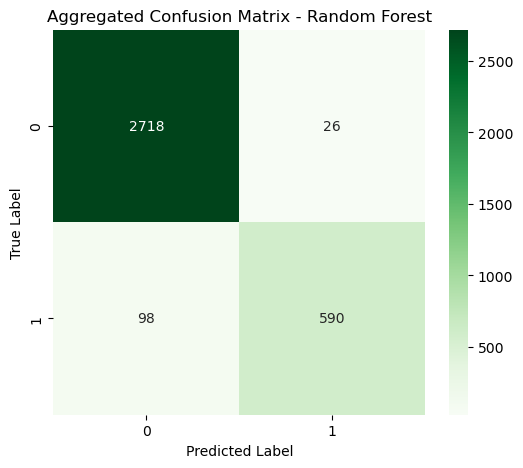

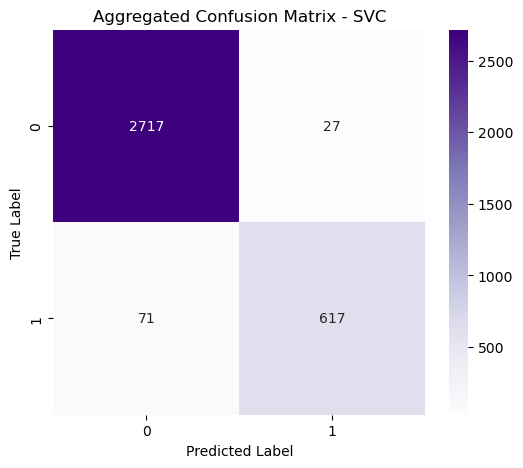

Aggregated Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2744
           1       0.87      0.83      0.85       688

    accuracy                           0.94      3432
   macro avg       0.92      0.90      0.91      3432
weighted avg       0.94      0.94      0.94      3432


Aggregated Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2744
           1       0.96      0.86      0.90       688

    accuracy                           0.96      3432
   macro avg       0.96      0.92      0.94      3432
weighted avg       0.96      0.96      0.96      3432


Aggregated Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2744
           1       0.96      0.90      0.93       688

    accuracy                

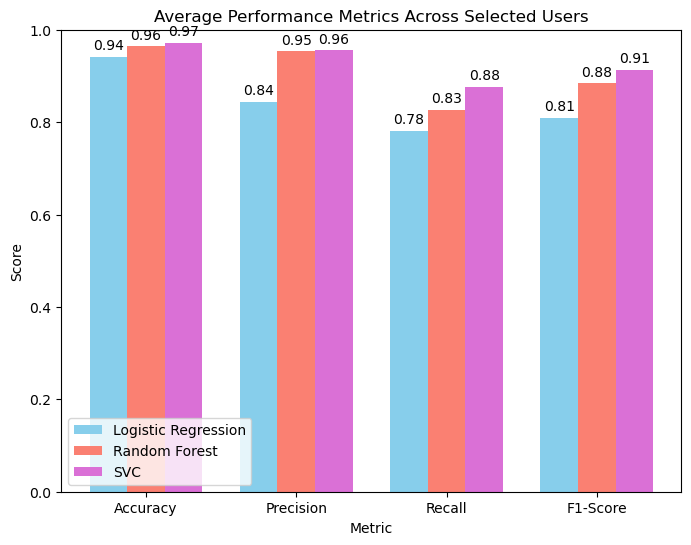

In [12]:
# Initialize aggregate confusion matrices for each model (2x2 arrays)
agg_cm_lr = np.zeros((2, 2), dtype=int)
agg_cm_rf = np.zeros((2, 2), dtype=int)
agg_cm_svc = np.zeros((2, 2), dtype=int)

# Lists to collect all true labels and predictions for overall classification reports
all_y_true_lr, all_y_pred_lr = [], []
all_y_true_rf, all_y_pred_rf = [], []
all_y_true_svc, all_y_pred_svc = [], []

# Lists to collect individual user metrics
lr_metrics = []
rf_metrics = []
svc_metrics = []

# Loop through each selected user and aggregate the metrics
for user in selected_users:
    X_train, y_train, X_test, y_test = train_test_data[user]
    
    # Logistic Regression evaluation for this user
    y_pred_lr = models_lr[user].predict(X_test)
    cm_lr = confusion_matrix(y_test, y_pred_lr)
    agg_cm_lr += cm_lr  # Aggregate confusion matrix
    all_y_true_lr.extend(y_test)
    all_y_pred_lr.extend(y_pred_lr)
    report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
    lr_metrics.append({
         'user': user,
         'accuracy': report_lr['accuracy'],
         'precision': report_lr['1']['precision'],
         'recall': report_lr['1']['recall'],
         'f1': report_lr['1']['f1-score']
    })
    
    # Random Forest evaluation for this user
    y_pred_rf = models_rf[user].predict(X_test)
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    agg_cm_rf += cm_rf  # Aggregate confusion matrix
    all_y_true_rf.extend(y_test)
    all_y_pred_rf.extend(y_pred_rf)
    report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
    rf_metrics.append({
         'user': user,
         'accuracy': report_rf['accuracy'],
         'precision': report_rf['1']['precision'],
         'recall': report_rf['1']['recall'],
         'f1': report_rf['1']['f1-score']
    })
    
    # SVC evaluation for this user
    y_pred_svc = models_svc[user].predict(X_test)
    cm_svc = confusion_matrix(y_test, y_pred_svc)
    agg_cm_svc += cm_svc  # Aggregate confusion matrix
    all_y_true_svc.extend(y_test)
    all_y_pred_svc.extend(y_pred_svc)
    report_svc = classification_report(y_test, y_pred_svc, output_dict=True)
    svc_metrics.append({
         'user': user,
         'accuracy': report_svc['accuracy'],
         'precision': report_svc['1']['precision'],
         'recall': report_svc['1']['recall'],
         'f1': report_svc['1']['f1-score']
    })

# Visualize aggregated confusion matrices for each model
plt.figure(figsize=(6,5))
sns.heatmap(agg_cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Aggregated Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(agg_cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Aggregated Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(agg_cm_svc, annot=True, fmt="d", cmap="Purples")
plt.title("Aggregated Confusion Matrix - SVC")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print aggregated classification reports for each model
print("Aggregated Classification Report for Logistic Regression:")
print(classification_report(all_y_true_lr, all_y_pred_lr))
print("\nAggregated Classification Report for Random Forest:")
print(classification_report(all_y_true_rf, all_y_pred_rf))
print("\nAggregated Classification Report for SVC:")
print(classification_report(all_y_true_svc, all_y_pred_svc))

# Compute average metrics for each model
lr_df = pd.DataFrame(lr_metrics)
rf_df = pd.DataFrame(rf_metrics)
svc_df = pd.DataFrame(svc_metrics)

lr_mean = lr_df[['accuracy', 'precision', 'recall', 'f1']].mean()
rf_mean = rf_df[['accuracy', 'precision', 'recall', 'f1']].mean()
svc_mean = svc_df[['accuracy', 'precision', 'recall', 'f1']].mean()

combined_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Logistic Regression': [lr_mean['accuracy'], lr_mean['precision'], lr_mean['recall'], lr_mean['f1']],
    'Random Forest': [rf_mean['accuracy'], rf_mean['precision'], rf_mean['recall'], rf_mean['f1']],
    'SVC': [svc_mean['accuracy'], svc_mean['precision'], svc_mean['recall'], svc_mean['f1']]
})

print("Aggregated Metrics Across Selected Users:")
print(combined_df)

# Plot a grouped bar chart comparing the three models on each metric, showing exact values on top
fig, ax = plt.subplots(figsize=(8,6))

x = np.arange(len(combined_df['Metric']))  # x positions for the metrics
width = 0.25  # width of each bar

lr_bar = ax.bar(x - width, combined_df['Logistic Regression'], width, label='Logistic Regression', color='skyblue')
rf_bar = ax.bar(x, combined_df['Random Forest'], width, label='Random Forest', color='salmon')
svc_bar = ax.bar(x + width, combined_df['SVC'], width, label='SVC', color='orchid')

# Annotate bars for Logistic Regression
for bar in lr_bar:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Annotate bars for Random Forest
for bar in rf_bar:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Annotate bars for SVC
for bar in svc_bar:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(combined_df['Metric'])
ax.set_xlabel("Metric")
ax.set_ylabel("Score")
ax.set_title("Average Performance Metrics Across Selected Users")
ax.set_ylim(0, 1)
ax.legend()
plt.show()


# **Biometric Swipe-Based Anomaly Detection System**

### **1. Introduction**
Biometric authentication leverages behavioral patterns to distinguish legitimate users from impostors. In this project, we develop a **swipe-based anomaly detection system** that learns user behavior and detects anomalies using **Binary Classification**.

We utilize **Logistic Regression, Random Forest, and SVC (Support Vector Classifier)** to classify swipe patterns as either **genuine (user-specific) or impostor**.


### **2. Machine Learning Approach**
A **binary classification approach** was employed, where:
- **Positive Samples (1):** Swipes belonging to the user being modeled.
- **Negative Samples (0):** Swipes from other users in the dataset.

This **user-specific modeling** allows for more personalized decision boundaries, leading to higher accuracy in distinguishing between a genuine user and an impostor.

### **2. Data Visualizations and Insights**
To better understand the dataset, the following visualizations were utilized:

**(a) Heat Map of Swipe Start Coordinates**: Swipes predominantly begin in a central region, suggesting common touch initiation areas.

**(b) Scatter Plot of Stroke Duration vs. Average Velocity**: Most swipes are quick and low-speed, with a handful of outliers exhibiting high velocity or long duration.

**(c) Swipe Trajectories**: The trajectory patterns reveal common swipe behaviors and highlight variability in user movement.

### **4. Data Cleaning**
- Non-informative columns (such as **document ID and phone ID**) were removed.
- Rows with **missing or infinite values** were dropped to ensure the dataset contains only valid, reliable biometric data for modeling.


### **5. Data Labeling**
- For **binary classification**, swipes from the target user were labeled as **positive (1)**.
- Swipes from other users in the selected group were labeled as **negative (0)**.


### **6. Feature Engineering**
- **StandardScaler** was used to **normalize features**, ensuring all features have equal weight in model training.
- **PCA (Principal Component Analysis)** was applied to **reduce dimensionality while retaining 90% of the variance**.
- This resulted in **15 principal components**, creating a **compact, informative feature set** that **reduces noise and redundancy**.
- The dimensionality reduction improves **computational efficiency** and **prevents overfitting**.


### **7. Model Training**
For each selected user, **binary classifiers** (**Logistic Regression, Random Forest, and SVC**) were trained on a **70/30 split** of the user’s data:

- **Positive samples:** Swipe data from the target user.
- **Negative samples:** Swipe data from other users in the selected group.

Each model is **user-specific**, meaning that a classifier is uniquely trained to **detect anomalies** for each user.

### **8. Model Evaluation**

The models were assessed using confusion matrices, classification reports, and aggregated metrics.

| Model               | Accuracy | Precision | Recall | F1-Score |
|---------------------|----------|-----------|--------|----------|
| Logistic Regression | 94.2%    | 84.4%     | 78.1%  | 80.9%    |
| Random Forest       | 96.4%    | 95.4%     | 82.7%  | 88.3%    |
| SVC                 | 97.1%    | 95.5%     | 87.6%  | 91.3%    |

- **SVC performed the best**, balancing **precision (95.5%)** and **recall (87.6%)**.
- **Random Forest was a strong alternative**, achieving **96.4% accuracy**.
- **Logistic Regression had the highest false negatives**, making it less reliable.

**Conclusion**
SVC is the **most effective model** for swipe-based anomaly detection, providing the best balance of accuracy, precision, and recall.

### **9. Reflection on Performance and Threat Model**

**(a) Primary Authentication**
This method is **not recommended** for primary authentication due to:
- **Variability in swipe behavior**, which could lead to **false rejections** (e.g., users under stress or changing conditions).
- **Ease of attack**—it may be easier to **mimic swipe patterns** compared to **guessing a password or PIN**.
- The system’s performance is dependent on **user consistency**, which may lead to **usability challenges**.

**(b) Secondary Authentication (Defense-in-Depth Strategy)**
This anomaly detection system can serve as an **additional layer of security** in a **Defense-in-Depth strategy**:

- If **primary credentials (e.g., passwords or PINs)** are compromised, the system can **detect anomalous swipe patterns**.
- When an **anomaly is detected**, the system can **trigger additional security mechanisms**, such as:
  - **Security questions**
  - **Biometric re-authentication**
  - **Multi-Factor Authentication (MFA)**

**Key Benefits of Integration**
By integrating this approach as a **secondary authentication mechanism**, organizations can:
- **Enhance overall account security**.
- **Reduce the risk of unauthorized access**, even if login credentials are stolen.
- **Detect compromised accounts** by monitoring behavioral patterns.

